# Approximating $\pi$ via Monte Carlo with MPI & IPyParallel

Using the method described in [this mpi tutorial](https://computing.llnl.gov/tutorials/mpi/#Abstract), we'll approximate using a parallel Monte Carlo algorithm as follows

- Generate $N$ random points in the square $[0,1] x [0,1]$
- $M$ of them will fall in the circle of radius .5 centered at $(.5,.5)$
- $\pi \approx 4M/N$

## Imports & verification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
%matplotlib inline
import ipyparallel as ipp

In [2]:
rc = ipp.Client(profile='mpi')

In [3]:
view = rc[:]
view.block = True

In [4]:
rc.ids

[0, 1, 2, 3]

In [5]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
print("Rank {}/{}".format(comm.rank, comm.size))

[stdout:0] Rank 3/4
[stdout:1] Rank 2/4
[stdout:2] Rank 0/4
[stdout:3] Rank 1/4


## Method 1: P2P Communication

[stdout:0] 
Rank 3: m=1960

[stdout:1] 
Rank 2: m=1936

[stdout:2] 
Rank 0: m=1920

N = 10000.0
M = 7764
pi ~= 3.10560

[stdout:3] 
Rank 1: m=1948



[output:2]

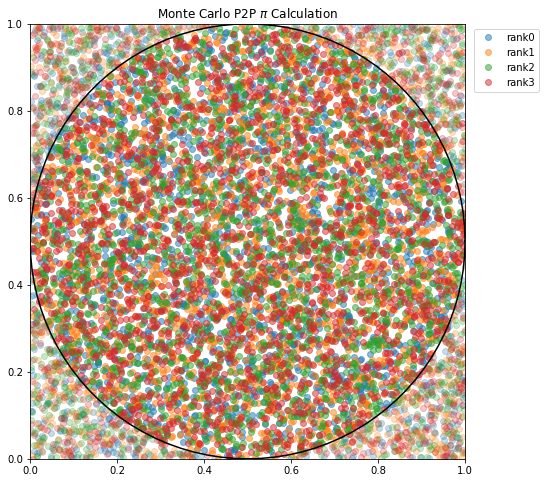

In [12]:
%%px
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.rank

N = 1e4
num_procs = comm.size

#print("Size = {}".format(comm.size))

alph_in = .5
alph_out = .25
# Round down to a multiple of num_procs
N -= N % num_procs

n = int(N / num_procs)

def in_circle(x,y):
    return ( (x-.5)**2 + (y-.5)**2 < .5**2)

def count_pts_in_circle(pts):
    return np.sum(in_circle(pts[:,0], pts[:,1]))

# Generate points
pts = np.random.rand(n,2)
m = count_pts_in_circle(pts)
outside = pts[~in_circle(pts[:,0], pts[:,1]),:]
inside = pts[in_circle(pts[:,0], pts[:,1]),:]

#print("m={}, inside={}".format(m, len(inside)))
#print("n-m={}, outside={}".format(n-m, len(outside)))
print("Rank {}: m={}".format(rank, m))
print()

del pts

# Send to rank 0
if rank != 0:
    comm.send(m, dest=0, tag=1)
    #comm.Send([pts, MPI.DOUBLE], dest=0, tag=2)
    comm.Send(outside, dest=0, tag=2)
    comm.Send(inside, dest=0, tag=3)

else:
    import matplotlib.pyplot as plt
    %matplotlib inline
    M = m
    
    fig = plt.figure(figsize=[8,8])
    ax = plt.gca()
    ax.set_aspect(1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    ax.plot(inside[:,0],inside[:,1], 'o', color='C0', alpha=alph_in, label='rank0')
    ax.plot(outside[:,0],outside[:,1], 'o', color='C0', alpha=alph_out)
    
    for proc in range(1, 4):
        # Count points
        m = comm.recv(source=proc, tag=1)
        M += m
        
        # Plot points
        outside = np.empty([n-m,2])
        inside = np.empty([m,2])
        comm.Recv(outside, source=proc, tag=2)
        comm.Recv(inside, source=proc, tag=3)
        ax.plot(inside[:,0],inside[:,1], 'o', color='C{}'.format(proc), alpha=alph_in, label='rank{}'.format(proc))
        ax.plot(outside[:,0],outside[:,1], 'o', color='C{}'.format(proc), alpha=alph_out)
        
        del inside, outside
    
    
    # Draw circle
    th = np.linspace(0,2*np.pi, 101)
    x = .5 * np.cos(th) + .5
    y = .5 * np.sin(th) + .5
    ax.plot(x, y, 'k-')
    
    plt.title('Monte Carlo P2P $\pi$ Calculation')
    plt.legend(loc='upper left', bbox_to_anchor=[1.01,1])
    
    print("N = {}".format(N))
    
    print("M = {}".format(M))
    print("pi ~= {:.5f}".format(4*M/N)) 
    print()
